Kaggle - Titanic Dataset
==============
----------------------------------------

A quick look at using the Kaggle [Titanic Dataset](https://www.kaggle.com/c/titanic/data) to demo the use of the python data stack.

_NOTE:_ The functions marked `datools` can be found in `datools.py` where they can be imported and used in other projects.

<br>
The following outline for the data set is taken from the Kaggle website:

----------------------------------------

### Overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

### Data Dictionary

```
Variable    Definition    Key
survival    Survival	  0 = No, 1 = Yes
pclass      Ticket class  1 = 1st, 2 = 2nd, 3 = 3rd
sex	        Sex
Age         Age in years
sibsp       # of siblings / spouses aboard the Titanic	
parch       # of parents / children aboard the Titanic	
ticket      Ticket number	
fare        Passenger fare	
cabin       Cabin number	
embarked    Port of Embarkation	 C = Cherbourg, Q = Queenstown, S = Southampton
```

### Variable Notes
```
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
```

In [1]:
%pylab inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from datools import *


sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=1.0)
plt.figure(figsize(12, 6))

DEFAULT_CMAP = 'RdYlBu_r'

Populating the interactive namespace from numpy and matplotlib


### Loading data from a csv and running some simple initial analysis

##### .head()
As with the unix command line program, this is useful for seeing the general layout of the data and what kind of values you can expect to find in each column.

##### .describe()
Some simple summary statistics computed for each numeric column.

##### show_percentage-null(df)
`datools`: Find the percentage of nulls in each dataframe column and print them.

##### show_missing_data(df)
`datools`: Display a quick heatmap of where we have missing data in a dataframe. (If not used in a notebook, this will open a plot window.)

In [2]:
DF = pd.read_csv('datasets/titanic/train.csv')
DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Encoding

Lets add some further encodings to the data so that we can make use of the categorical columns `Sex` and `Embarked`.

In [3]:
sex_encoding = {'male': 0, 'female': 1}
embarked_encoding = {'C': 0, 'Q': 1, 'S': 2}
DF['Sex'] = DF['Sex'].apply(lambda r: sex_encoding.get(r))
DF['Embarked'] = DF['Embarked'].apply(lambda r: embarked_encoding.get(r))

DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0


In [4]:
DF.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,1.535433
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


Age: 19.87% NULL
Cabin: 77.1% NULL
Embarked: 0.22% NULL


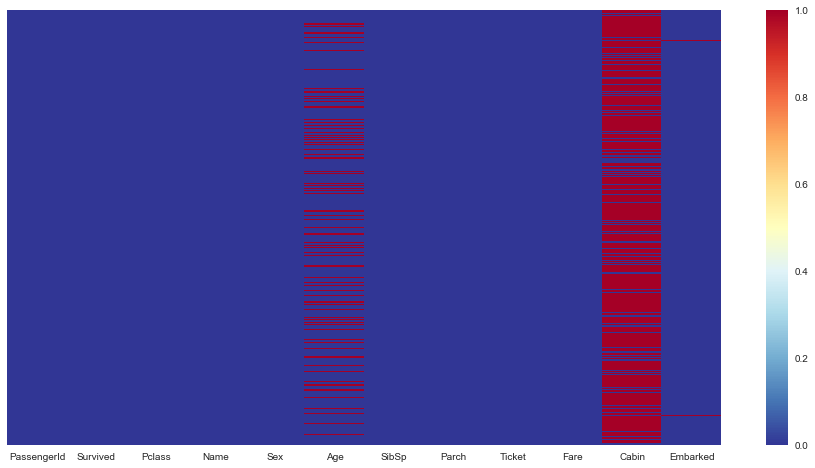

In [5]:
show_percentage_null(DF)
show_missing_data(DF)

So, in this case we have a lot of missing data in the `Cabin` column (almost all of it!), a small amount in `Embarked` and around 20% of the `Age` column.

Cabin is pretty much useless to us, but embarked and Age can probably be saved with a little cleaning.

### Cleaning up Age and Embarked

We could do a simple insertion of the mean in place of any missing `Age` values but lets have a look at the distribution of age verses some of the other paramaters that we have access to. (We might be able to do a bit better)

For `Embarked`, there are so few values that dropping them will be easier.

_NOTE: Here I'm using the pandas pivot table feature to reshape our DataFrame to make plotting a lot easier_

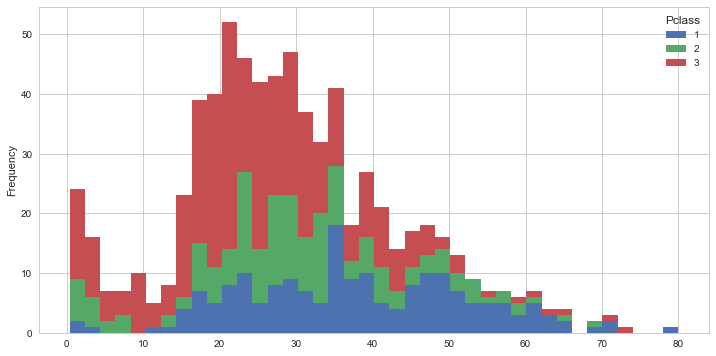

In [6]:
DF.pivot(index='PassengerId', columns='Pclass', values='Age').plot(kind='hist', stacked=True, bins=40)

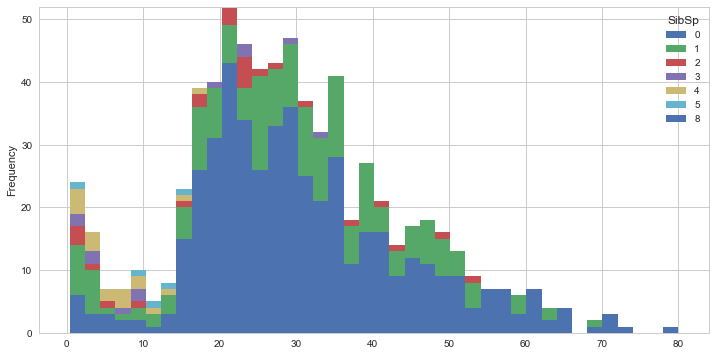

In [7]:
DF.pivot(index='PassengerId', columns='SibSp', values='Age').plot(kind='hist', stacked=True, bins=40)

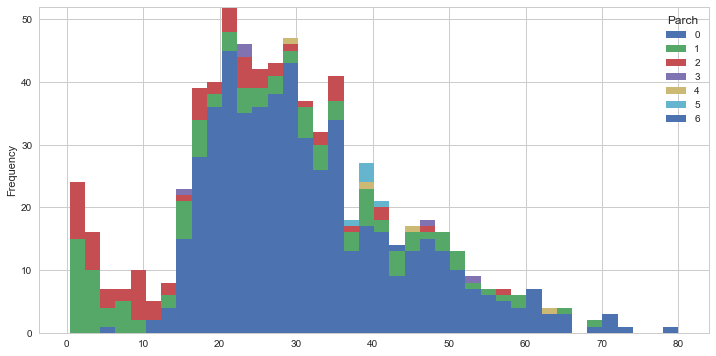

In [8]:
DF.pivot(index='PassengerId', columns='Parch', values='Age').plot(kind='hist', stacked=True, bins=40)

So, at a glance it looks like `Parch` and `SibSp` aren't going to be that useful to us but `Pclass` will be.

Lets clean this up. While we're at it we'll also drop the `Name` and `Ticket` columns are there isn't much we can do with those once we get to training a model.

##### fill_na_with_grouped_means(df, fill_column, grouping_column)
`datools`: Compute the grouped means of a `fill_column` when partitioned by `grouping_column` and use these to fill any missing values. Mean values will be rounded to `dp` decimal places.

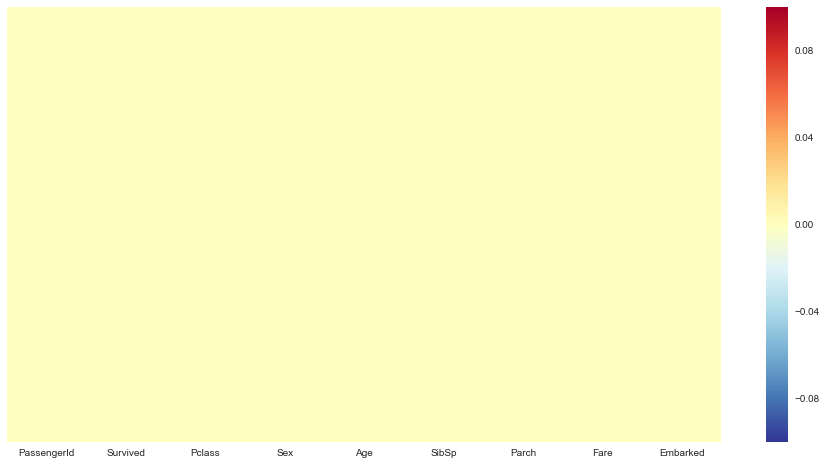

In [9]:
fill_na_with_grouped_means(DF, fill_column='Age', grouping_column='Pclass')
DF.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
DF.dropna(axis=0, inplace=True)

show_percentage_null(DF)
show_missing_data(DF)

### Some quick looks at the distribution of the data now we've tidied it up

We're trying to predict who survived so lets break things down based on that.

As per the Data dictionary provided with the dataset; `0` indicates the passenger died and `1` indicates that they survived.

This first plot is a nice way to eyeball correlations between each of the columns in the data set. The others have been selected to get a closer look at interesting pairings identified from the `pairplot`.

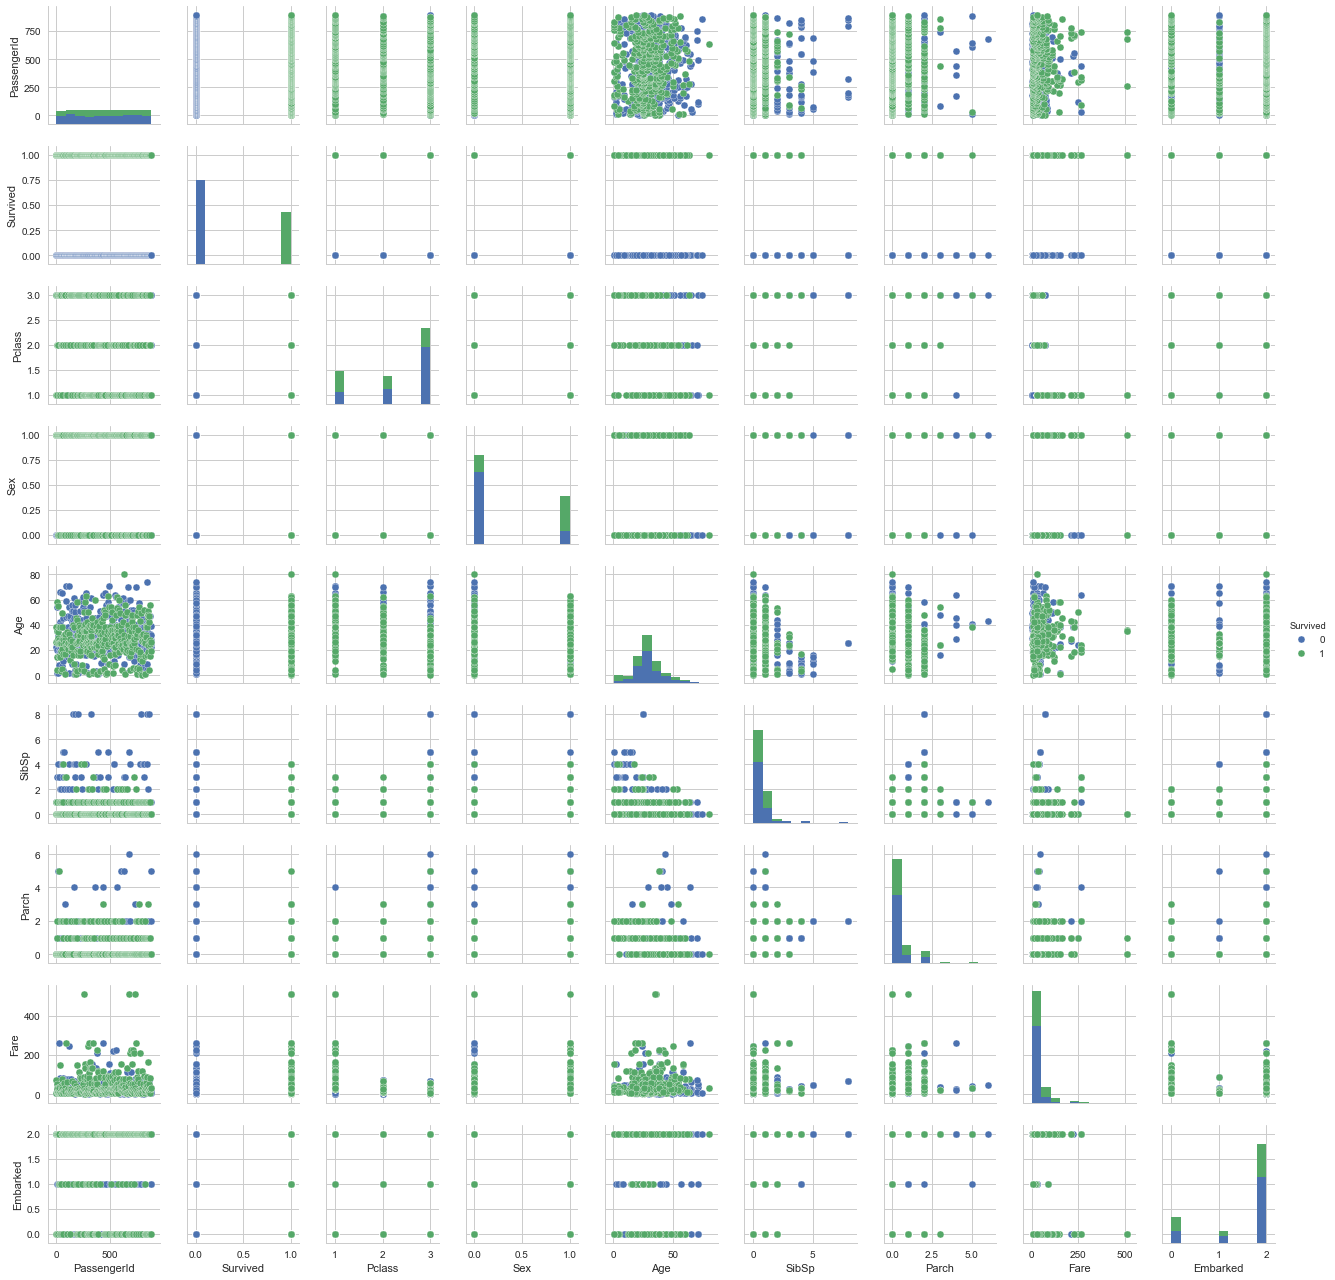

In [10]:
sns.pairplot(DF, hue='Survived', markers=['o', 'o'], size=2)

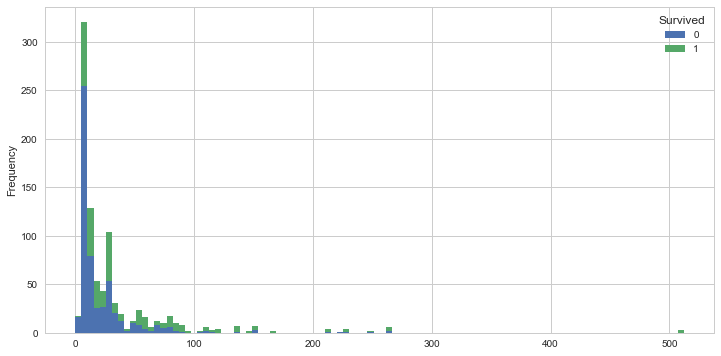

In [11]:
DF.pivot(index='PassengerId', columns='Survived', values='Fare').plot(kind='hist', stacked=True, bins=100)

Fairly large tail on the distribution for `Fare`. (Also, not much of a predictor it seems)

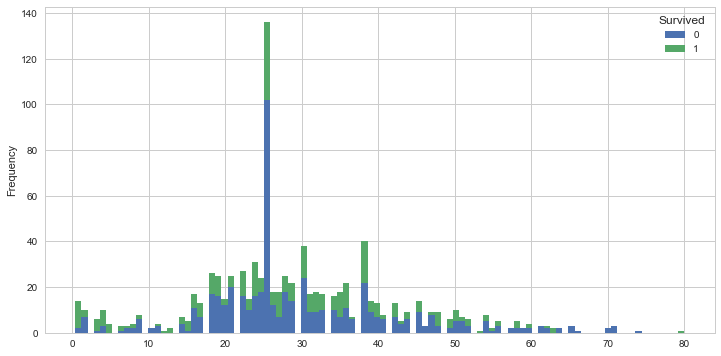

In [12]:
DF.pivot(index='PassengerId', columns='Survived', values='Age').plot(kind='hist', stacked=True, bins=100)

Similar for `Age`, there doesn't seem to be a cut-off anywhere (i.e. "most children/elderly passengers died")

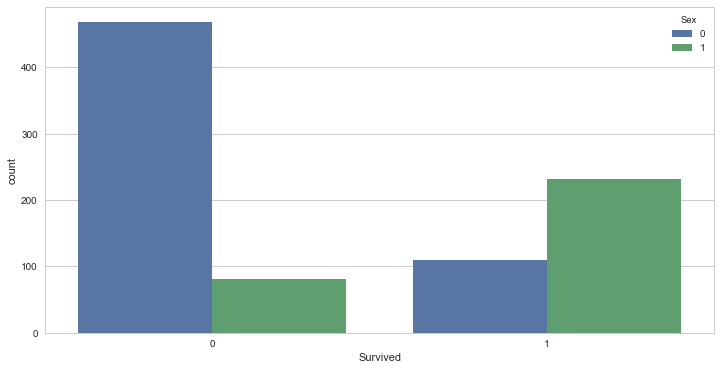

In [13]:
sns.countplot('Survived', data=DF, hue='Sex')

`Sex` seems more important for us as most women seem to have survived.

The other columns don't seem to get us much from looking at the pair-plot so lets just try training a model with what we have so far.

### Training a model
For a first pass at training a model, we're going to use a simple [Logistic Regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) model from scikit-learn. [scikit-learn](http://scikit-learn.org/stable/) has a number of [helper functions](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) for partitioning training sets and checking model performance so we'll make use of those as well.

In [14]:
X = DF.drop('Survived', axis=1)
y = DF['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy score of: {}%".format(round(accuracy_score(y_test, predictions) * 100, 2)))

             precision    recall  f1-score   support

          0       0.83      0.86      0.84       167
          1       0.75      0.71      0.73       100

avg / total       0.80      0.80      0.80       267

Accuracy score of: 80.15%


80% accuracy without doing much more than cleaning up the data and punting to scikit-learn. Not bad!